In [221]:
import numpy as np
from utils import es_utils as es
from utils import itd_utils as itd
from utils import prob_utils as prob

import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

from python_speech_features import logfbank

from scipy.io import wavfile
import re
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import gammamix
import matplotlib.ticker as ticker

from tqdm import tqdm

In [30]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{xcolor}', r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Computer Modern Sans serif' # Choose a nice font here
plt.rcParams['font.size'] = 18

In [35]:
basedir = '/Data/DATASETS/CAESAR_TIDIGITS/'
# basedir = '/home/enea/Downloads/ex_manual_itds/priors/'
filename = basedir + 'priors/' + 'prior_long_hv_0'
imgs_folder = './imgs/'
num_bins = 80
max_itd = 800e-6
num_channels = 64

# load file
timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[1000:]
addresses = addresses[1000:]

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

#remove trigger

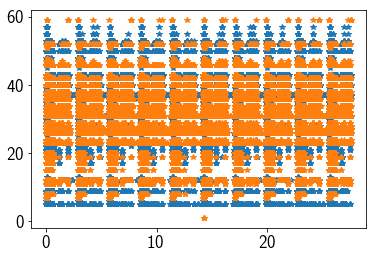

In [36]:
a, b = 0, 1000000
plt.plot(timestamps[ear_id==0][a:b], channel_id[ear_id==0][a:b] % 64, '*')
plt.plot(timestamps[ear_id==1][a:b], channel_id[ear_id==1][a:b] % 64, '*')

In [37]:
dict_c = {}

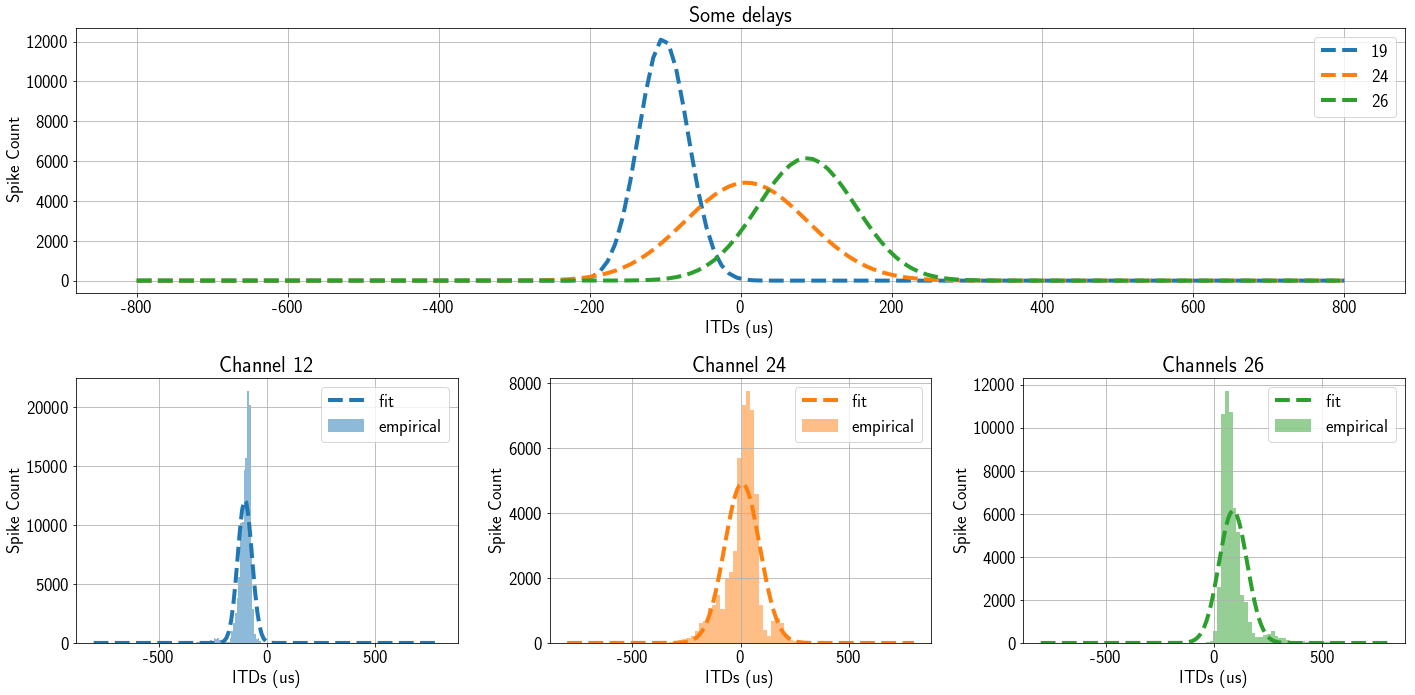

In [190]:
from scipy.stats import norm
fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 1))
ax4 = plt.subplot2grid((2, 3), (1, 2))

filename = basedir + 'priors/' + 'prior_long_hv_{}'.format(90)

timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[10000:]
addresses = addresses[10000:]
timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

for i in range(0,64):
    w = channel_id == i
    try:
        _itds, _ = itd.get_itds(timestamps[w], ear_id[w], neuron_id[w], save_to_file=None,
                                 verbose=False, max_itd=max_itd)

        mu, std = norm.fit(_itds)
        if not np.isnan(mu):
            dict_c[i] = {'mu': mu, 'std':std}
            x = np.linspace(-max_itd, max_itd, 160)
            p = norm.pdf(x, mu, std)
            if i in [19, 24, 26]:
                ax1.plot(x, p, '--', label=i, linewidth=4)
#                 ax1.set_xticklabels([-1, -.8, .0, .8])
#                 ax1.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
                if i == 19:
                    ax2.hist(_itds, 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(0))
                    ax2.plot(x, p, '--', label='fit', linewidth=4, c = plt.cm.tab10(0))
#                     ax2.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
                if i == 24:
                    ax3.hist(_itds, 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(1))
                    ax3.plot(x, p, '--', label='fit', linewidth=4, c = plt.cm.tab10(1))
#                     ax3.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
                if i == 26:
                    ax4.hist(_itds, 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(2))
                    ax4.plot(x, p, '--', label='fit', linewidth=4, c = plt.cm.tab10(2))
#                     ax4.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
#             if not np.isnan(mu):
#                 print "CH: {:4} || MU: {:4} || SIGMA: {:4}".format(i, mu, std)
    except:
        pass

scale_x = 1e-6
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))

title = ['Some delays', 'Channel 12', 'Channel 24', 'Channels 26']
for ax, t in zip([ax1, ax2, ax3, ax4], title):
    ax.legend()
    ax.grid()
    ax.set_title(t)
    ax.set_xlabel('ITDs (us)')
    ax.set_ylabel('Spike Count')
    ax.xaxis.set_major_formatter(ticks_x)


plt.tight_layout()
plt.savefig(imgs_folder + 'example_correction.pdf', transparent=True)

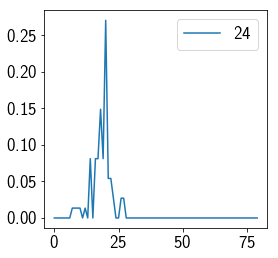

In [6]:
base = '/home/enea/Downloads/'
filename = base + 'NT8202009JA409'
    
timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[10000:]
addresses = addresses[10000:]
timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

fig = plt.figure(figsize=(4,4))
for i in [24]:
    ax = fig.add_subplot(1,1,1)
    
    w = channel_id == i
    try:
        _itds, _ = itd.get_itds(timestamps[w], ear_id[w], neuron_id[w], save_to_file=None,
                             verbose=False, max_itd=max_itd)
        ax.plot(prob.get_priors(np.array([_itds]))[0], label=i)
    except:
        pass
plt.legend()

In [222]:
relevant_channels = np.arange(64)
r_ch = np.array([19])
itd_streams = []
itd_streams_no_corr = []
itd_streams_no_corr_lim = []
for i in tqdm(range(0, 190, 10)):
    filename = basedir + 'priors/prior_long_hv_{}'.format(i)

    timestamps, addresses = es.loadaerdat(filename + '.aedat')
    timestamps = timestamps[10000:]
    addresses = addresses[10000:]
    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    l = len(timestamps)
    perc = int(len(timestamps) * 100 / 100)

    p = np.random.permutation(l)[:perc]

    timestamps = timestamps[p]
    channel_id = channel_id[p]
    ear_id = ear_id[p]
    neuron_id = neuron_id[p]
    _ii = []
    _ii_no_corr = []
    _ii_no_corr_lim = []
    for kk in relevant_channels:
        indices_channels = np.isin(channel_id, np.array([kk]))
        if kk in dict_c:
            try:
                _itds, _ = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd)
                _mu = dict_c[kk]['mu']
                _corr = (_itds - _mu)
                _ii.extend(_corr)
                _ii_no_corr.extend(_itds)
                if kk in r_ch:
                    _ii_no_corr_lim.extend(_itds)
            except Exception as e:
                print e
    itd_streams.append(_ii)
    itd_streams_no_corr.append(_ii_no_corr)
    itd_streams_no_corr_lim.append(_ii_no_corr_lim)

100%|██████████| 19/19 [02:18<00:00,  7.33s/it]


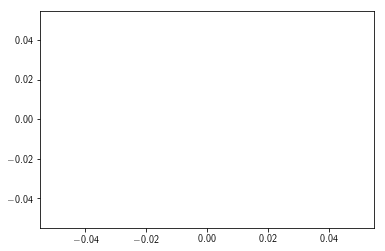

In [226]:
from scipy.stats import gamma
lnspc = m
ag,bg,cg = gamma.fit(itd_streams[0])  
pdf_gamma = gamma.pdf(lnspc, ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

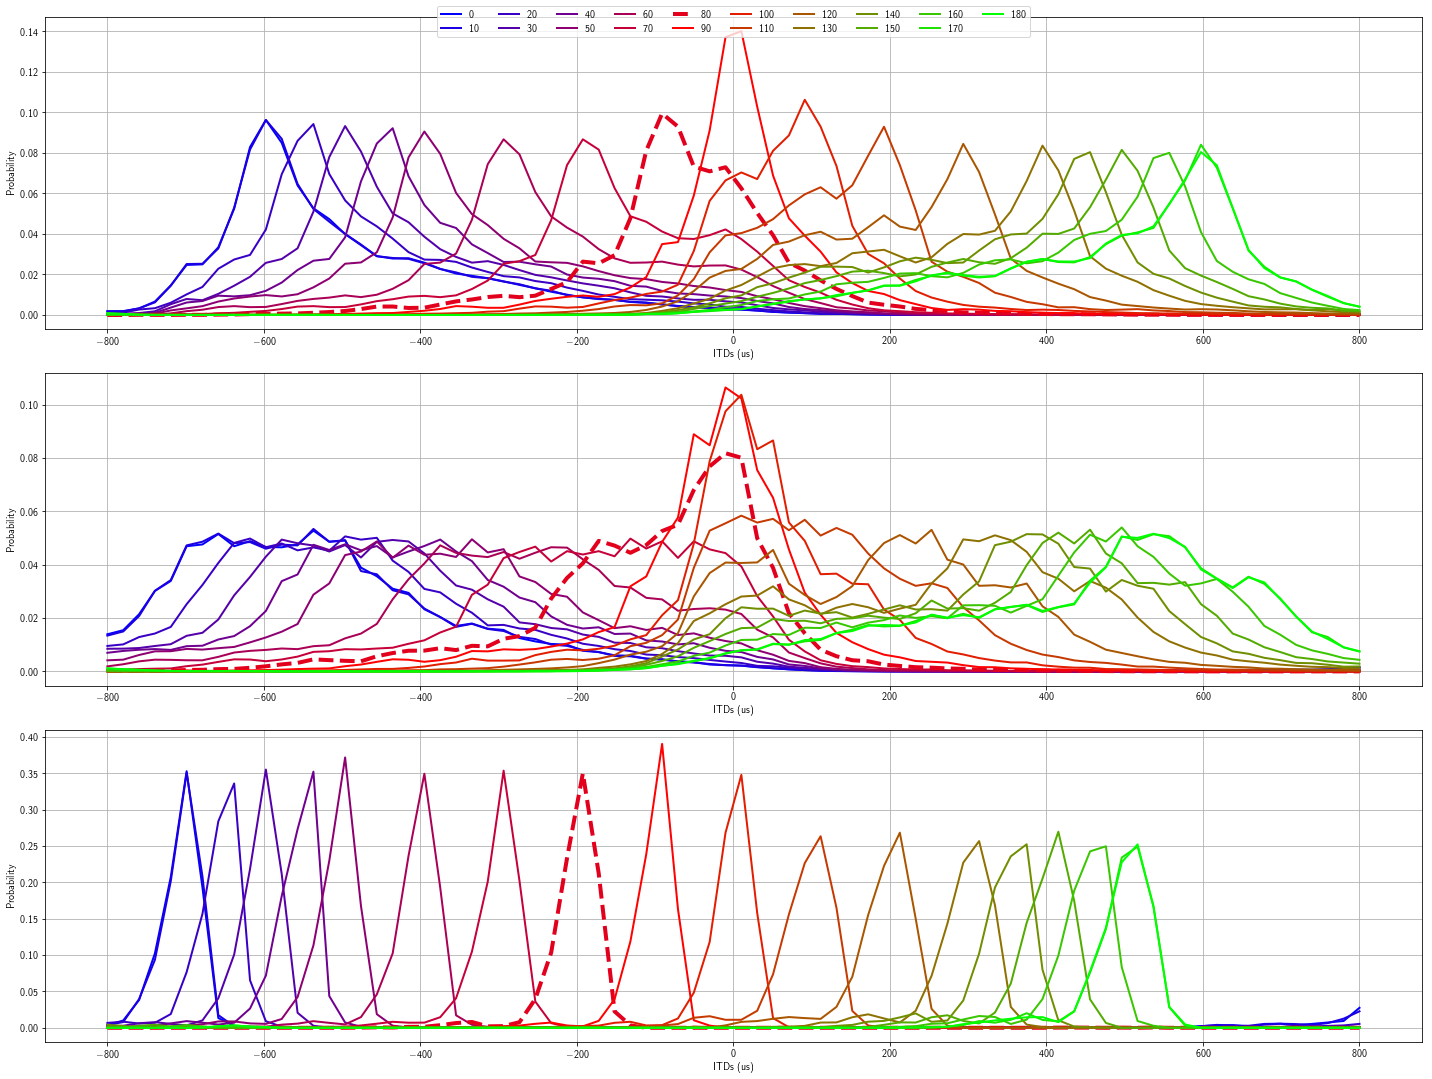

In [223]:
fig = plt.figure(figsize=(20,15))
x = np.linspace(-max_itd * 1e6, max_itd * 1e6, 80)
ax = fig.add_subplot(3,1,1)
priors = prob.get_priors(np.array(itd_streams))
color_idx = np.linspace(0, 1, 19)
for i, l, j in zip(color_idx, range(0, 190, 10), priors): 
    c = plt.cm.brg(i)
    ax.plot(x, j, '--' if l == 80 else '-', label=l, linewidth=4 if l == 80 else 2, color=c)
    
ax.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=10, fancybox=True)
ax.set_xlabel('ITDs (us)')
ax.set_ylabel('Probability')
# ax.set_title([i for i in np.arange(0, 64) if i in dict_c])

ax = fig.add_subplot(3,1,2)
priors = prob.get_priors(np.array(itd_streams_no_corr))
for i, l, j in zip(color_idx, range(0, 190, 10), priors): 
    c = plt.cm.brg(i)
    ax.plot(x, j, '--' if l == 80 else '-', label=l,linewidth=4 if l == 80 else 2, color=c)
ax.grid()
# ax.legend()
ax.set_xlabel('ITDs (us)')
ax.set_ylabel('Probability')
# ax.set_title([i for i in np.arange(0, 64) if i in dict_c])

ax = fig.add_subplot(3,1,3)
priors = prob.get_priors(np.array(itd_streams_no_corr_lim))
for i, l, j in zip(color_idx, range(0, 190, 10), priors): 
    c = plt.cm.brg(i)
    ax.plot(x, j, '--' if l == 80 else '-', label=l, linewidth=4 if l == 80 else 2, color=c)
ax.grid()
# ax.legend()
ax.set_xlabel('ITDs (us)')
ax.set_ylabel('Probability')
# ax.set_title("[19]")

plt.tight_layout()
plt.savefig(imgs_folder + 'comparison_priors.pdf', transparent=True)

In [805]:
print "I can use more spikes with the correction"
print sum([len(i) for i in itd_streams])
print sum([len(i) for i in itd_streams_no_corr])
print sum([len(i) for i in itd_streams_no_corr_lim])
print sum([len(i) for i in itd_streams]) / sum([len(i) for i in itd_streams_no_corr_lim])

I can use more spikes with the correction
6365429
6365429
168477
37


In [ ]:
plt.figure(figsize=(12,12))
priors = prob.get_priors(np.array(itd_streams))
for l, j in zip(range(0, 190, 10), priors): 
    plt.plot(j, label=l)
plt.legend()
plt.title([i for i in np.arange(0, 65) if i in dict_c])

In [ ]:
np.save('priors_long_hv_corrected_all', priors)
import pickle as pkl
pkl.dump(dict_c, open('correction_dict.pkl', 'w'))

In [ ]:
np.save('priors_long_hv_corrected_10_30', priors)

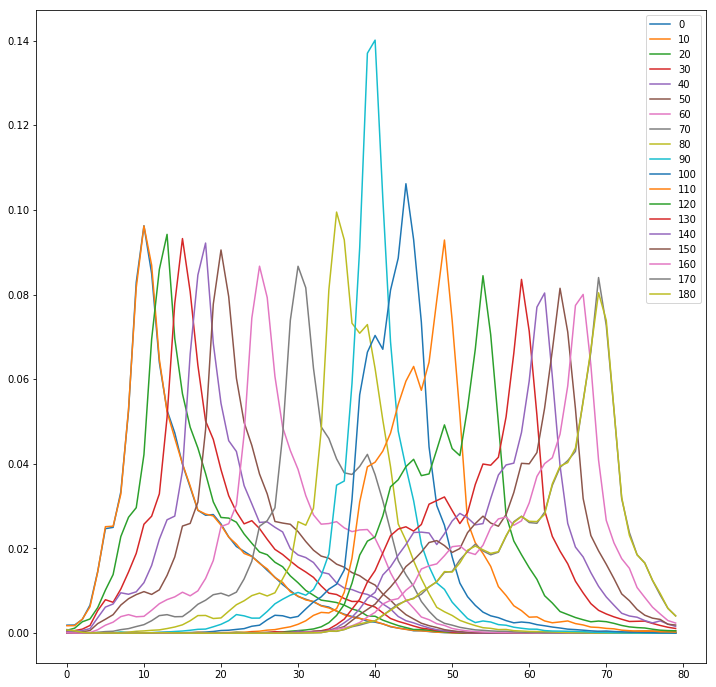

In [6]:
priors = np.load('priors_long_hv_corrected_all.npy')
plt.figure(figsize=(12,12))
for l, j in zip(range(0, 190, 10), priors): 
    plt.plot(j, label=l)
plt.legend()

In [38]:
def remove_trigger(timestamps, addresses):
    dx = 0.000001
    idx =  np.argmax(np.diff(timestamps)/dx)
    return timestamps[idx + 1:], addresses[idx + 1:]

(19, 80)


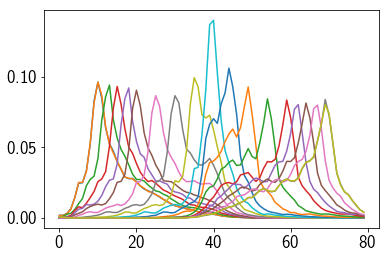

In [39]:
priors = np.load('priors_long_hv_corrected_all.npy')
dict_c = pkl.load(open('correction_dict.pkl', 'r'))
itd_dict = itd.get_itd_dict(max_itd, num_bins)*1e6
_ = plt.plot(priors.T)
print priors.shape

In [40]:
with open(basedir + 'log_train.txt') as t:
    all_angles = [x for x in t.readlines()]

In [167]:
all_train = []
gts1 = []
gts2 = []
with open('train_set.txt') as t:
    all_train = [line.split(' ')[4].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    gts1 = [line.split(' ')[0].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    gts2 = [line.split(' ')[1].strip() for line in t.readlines()]

IDX = 2020
print all_train[IDX]
print all_angles[IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat/train/' + all_train[IDX] + '.aedat')
timestamps, addresses = remove_trigger(timestamps, addresses)

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

# load wav
spk1, spk2, _ = re.compile('[0-9]+').split(all_train[IDX])
_, utt1, utt2 = re.compile('[A-Z]+').split(all_train[IDX])
pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
print pos1
print pos2
fs, w1 = wavfile.read(basedir + 'wavs/train/' + gts1[IDX].replace('\\', '/') + '.wav')
fs, w2 = wavfile.read(basedir + 'wavs/train/' + gts2[IDX].replace('\\', '/') + '.wav')

KD8098968FC0
KD8098968FC0 120.000000 60.000000 

12
6


In [168]:
from collections import OrderedDict
import itertools
idx_dict = {}
_aa = {}
for kk in np.arange(0,64):
    indices_channels = np.isin(channel_id, np.array([kk]))
    if kk in dict_c:
        try:
            _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                 verbose=False, max_itd=max_itd)
            idx_dict[kk] = _itd_idx
            _mu = dict_c[kk]['mu']
            _corr = (_itds - _mu)  # / dict_c[kk]['std'] * dict_c[19]['std']
            _aa[kk] = _corr
        except Exception as e:
            pass


In [169]:
sigma = 20
index_angles = np.vstack([np.arange(19), np.arange(0, 190, 10)]).T

num_angles = len(priors)
initial_estimate = np.ones(num_angles) / num_angles # all angles are a priori equally likely
transition_probabilities = prob.get_transition_probabilities(index_angles, sigma=sigma) # gaussian a priori probability of itds given a certain position
itd_dict = itd.get_itd_dict(max_itd, num_bins) # array holding the mean values of all itd bins
arg = {}
for k, _a in _aa.iteritems():
    estimates, argmax_estimates = prob.estimate(_a, initial_estimate, transition_probabilities, itd_dict, priors)
    arg[k] = argmax_estimates

argmax_estimates = []
for k, v in arg.iteritems():
    argmax_estimates.extend(v)
argmax_estimates = np.array(argmax_estimates)

In [170]:
def wind_sp(ts, ch, w=0.001):
    ts_int = (ts // w).astype('int32')

    A = np.zeros((np.max(ts_int) + 1, max(list(set(ch))) + 1))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 1
    
#     A = np.minimum(A, np.ones_like(A))
    # returning [ch, T]
    return A.T

def exp_feat(A, win=0.05, tpe='lap', l=300):
    if tpe == 'exp':
        t = np.arange(0, win, 0.001)
        b = np.exp(-l * t)
    elif tpe == 'lap':
        t = np.arange(-win, win, 0.001)
        b = np.exp(-l * np.abs(t))
        
    b /= np.linalg.norm(b)
    AA = np.array([np.convolve(_a, b, 'same') for _a in A])
    return AA

def smear_fr(A, win=3, l=10):
#     t = np.arange(-win, win, 1)
#     b = np.exp(-l * np.abs(t))
    b = np.concatenate([np.arange(win), np.arange(win)[::-1]])
    A = np.array([np.convolve(_a, b, 'same') for _a in A.T])
    return A.T

def simple_low_pass(X, win=25, shift=10):
    n_win = (X.shape[0] - win) // shift
    XX = np.zeros((n_win, X.shape[1]))
    for i in range(0, n_win):
        XX[i] = np.sum(X[i * shift: (i + 1) * shift] , 0) / win
    return XX

In [171]:
T = []
C = []
for p in [pos1, pos2]:
    T1 = []
    C1 = []
    for ch in idx_dict.keys():
        t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == p]]
        T1.extend(t)
        C1.extend(np.ones_like(t) * ch)
    T.append(T1)
    C.append(C1)

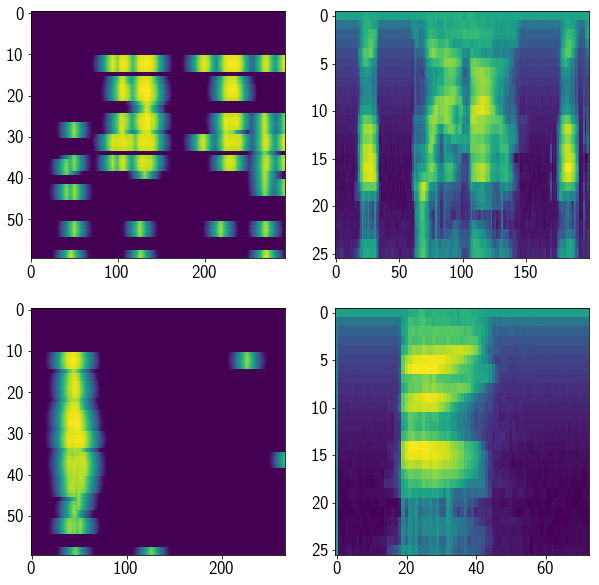

In [172]:
fig = plt.figure(figsize=(10,10))

for T1, C1, k, w in zip(T, C, range(2), [w1, w2]):
    A = wind_sp(np.array(T1), np.array(C1).astype('int32'))
    AA = exp_feat(A, win=0.3, l=100, tpe='lap')
    AAA = smear_fr(AA, win=3)
    AAAA = simple_low_pass(AAA.T).T

    
    ax = fig.add_subplot(2, 2, k*2 + 1)
    ax.imshow(np.log(AAAA + 1e-9)[:, :400], aspect='auto')
    
    ax = fig.add_subplot(2, 2, k*2+2)
    Y = logfbank(w, fs, nfft=1024)
    ax.imshow(Y.T[:, :200], aspect='auto')

70
130
12
6


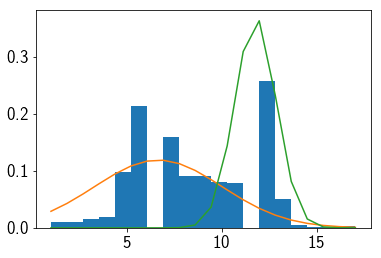

In [177]:

A = np.arange(0, 200, 10)
a = plt.hist(argmax_estimates, 19, normed=True)

gmm = GaussianMixture(2, n_init=20)
gmm.fit(argmax_estimates.reshape(-1,1))

g1 = norm.pdf(a[1], gmm.means_[0], gmm.covariances_[0][0])
g2 = norm.pdf(a[1], gmm.means_[1], gmm.covariances_[1][0])
# g3 = norm.pdf(a[1], gmm.means_[2], gmm.covariances_[2][0])
plt.plot(a[1], g1)
plt.plot(a[1], g2)
# plt.plot(a[1], g3)

print A[np.argmax(g1)]
# print gmm.weights_
print A[np.argmax(g2)]
# print A[np.argmax(g3)]

# fig = plt.figure(figsize=(12,6))


# for i, pos in enumerate([np.argmax(g1), np.argmax(g2)]):
#     ax = fig.add_subplot(1,2,i + 1)
#     for ch in idx_dict.keys():
# #         d = np.where(np.array(idx_dict.keys()) == ch)[0][0]
#         t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == pos]]
#         ax.plot(t, np.ones_like(t) * ch,  '*')

print pos1
print pos2

In [178]:
results = gammamix.gammamix_em(
                np.array(argmax_estimates+1),
                #initial guess at the mixing proportion
                mix_prop=np.array([0.5, 0.5]),
                verb=True)

initial vals: [0.5 0.5] [24.44138252 65.63437076] [3.48759397 5.42176658] 2
Number of iterations= 2


8
0


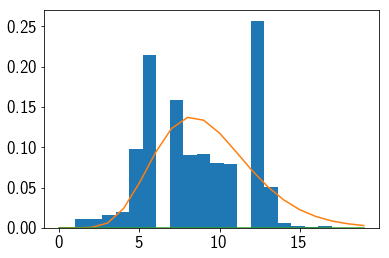

In [179]:
a = plt.hist(argmax_estimates, 19, normed=True)

pdf_gamma = stats.gamma.pdf(np.arange(20)+1, results[0].alpha[0], results[0].invbeta[0], results[0].mix_prop[0])
plt.plot(np.arange(20), pdf_gamma, label="Gamma")
print np.argmax(pdf_gamma)

pdf_gamma = stats.gamma.pdf(np.arange(20)+1, results[0].alpha[1], results[0].invbeta[1], results[0].mix_prop[1])
plt.plot(np.arange(20), pdf_gamma, label="Gamma")

print np.argmax(pdf_gamma)